# Analysis of Austin Animal Center Shelter Outcome dataset
Trying to model the outcomes of animals at the Austin Animal Center Shelter, using the [Austin Animal Center Shelter Income and Outcome dataset (Kaggle).](https://www.kaggle.com/datasets/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes) <br>

By Dar Mendelowitz

## Imports

In [1]:
# Data processing
import pandas as pd
import numpy as np

# Statistics
from scipy.stats import chi2_contingency

# Data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning library
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
# import shap

# Helper functions
from utils import print_animal_count, get_top_k, set_top_k_colors, convert_to_years, sort_colors
from missing_values import print_animal_ids, get_missing_animal_ids, get_existing_animal_ids_in_dataset
from missing_values import filter_null_values, update_column

import warnings
warnings.filterwarnings("ignore")

## Loading the Austin Animal Center Shelter Outcome dataset

In [2]:
# Loading the CSV dataset
df_in_out = pd.read_csv("./data/aac_intakes_outcomes.csv")
df_in = pd.read_csv("./data/aac_intakes.csv")
df_out = pd.read_csv("./data/aac_outcomes.csv")
dtf = df_out

# Defining the columns
cols = ["age_upon_outcome", "animal_id", "animal_type", "breed", "color", "date_of_birth", "datetime", "monthyear",
        "name", "outcome_subtype", "outcome_type", "sex_upon_outcome"]
dtf = dtf[cols]

In [3]:
dtf.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [4]:
dtf.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,80673,80681,80681,80681,80681,80681,80681,80681,56116,36893,80667,80679
unique,46,72877,5,2176,532,5956,66474,66474,14824,19,9,5
top,1 year,A721033,Dog,Domestic Shorthair Mix,Black/White,2015-09-01T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male
freq,14911,13,45856,23821,8396,112,39,39,362,20082,34232,28702


In the table above, the number of animals in the shelter is 80681 (the count of unique 'animal_id' entries). However, not all columns contain 80681 values, as some entries are missing (NaN values).

For instance:

* The column 'age_upon_outcome' contains slightly fewer values, specifically 80673 entries.
* The 'name' column has significantly fewer entries, totaling 56116.
* In the 'outcome_subtype' column, there are even fewer entries, with only 36893 values present, which is less than half of the total number of animals in the shelter.
* Additionally, both the 'outcome_type' and 'sex_upon_outcome' columns have fewer entries.

Moreover, the number of unique 'animal_id' entries is less than the overall number of 'animal_id' entries (72877 < 80681). This discrepancy occurs because some animals have returned to the shelter. For example, a cat named Elsa (animal_id: A684460) was initially adopted (first outcome) at the age of 2 months. However, she was later returned to the shelter (sadly, her owner surrendered her at the age of 1 year, according to the aac_intakes_outcomes.csv table). After 25 days, Elsa was transferred to another shelter (second outcome).

***

### A first examination of the target feature - 'outcome_type':

A histogram of the target feature 'outcome_type':

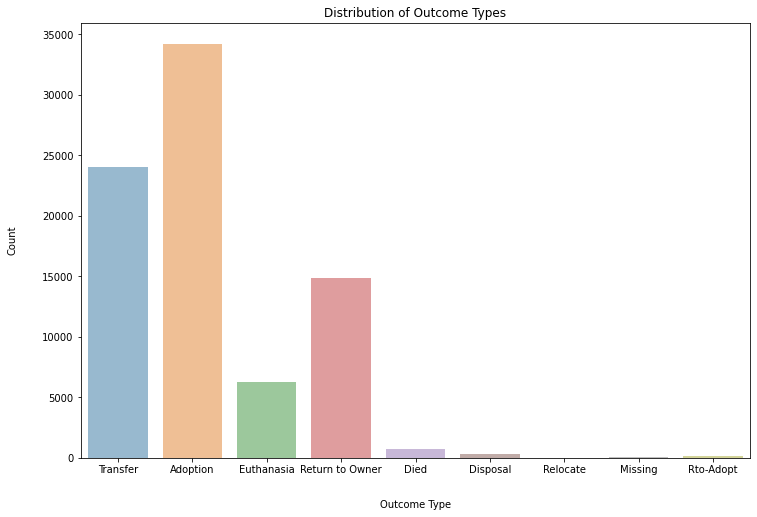

In [5]:
plt.figure(figsize=(12, 8))
sns.countplot(data=dtf, x='outcome_type', alpha=0.5)
plt.title('Distribution of Outcome Types')
plt.xlabel('Outcome Type', labelpad=25)
plt.ylabel('Count', labelpad=25)
plt.show()

We can see that most animals were adopted (almost 35,000 animals). Almost 25,000 animals were transfered (to another shelter), about 15,000 were returned to their original owners, a little bit more than 5000 were euthanized. A small number of animals have died, an even smaller number were disposed, relocated, missing or Rto-Adopted.

Overall, most animals either were adopted, transfered, returned to owner or euthanized.

In [6]:
outcome_list = ['Return to Owner', 'Transfer', 'Adoption', 'Euthanasia', 'Died', 'Rto-Adopt', 'Missing', 'Disposal',
                'Relocate']

***

## Viewing the Baseline Model

***The basic model will later be compared to the final model.***

### Training the basic model and predicting

In [7]:
# Initialize the label encoder
encoder = LabelEncoder()

In [16]:
# Drop 'animal_id' column from the dataframe
dtf_model = dtf.drop('animal_id', axis=1)

# List of categorical columns to encode
categorical_columns = ['breed', 'color', 'name', 'outcome_subtype', 'sex_upon_outcome', 'outcome_type', 'animal_type']

# Encode categorical columns
for column in categorical_columns:
    dtf_model[column] = encoder.fit_transform(dtf_model[column])

In [17]:
# Separate features and target variable
X = dtf_model.drop('outcome_type', axis=1)  # Features
y = dtf_model['outcome_type']  # Target variable

# split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Initialize the model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [19]:
# Fit the model on the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [20]:
# Predict on the test data
y_pred = model.predict(X_test)

### Evaluating the model

In [21]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 89.23%


In [22]:
# Perform 10-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=10)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.87991077 0.88249876 0.85647    0.88063956 0.89762023 0.90195835
 0.90307387 0.89638076 0.89786812 0.90183441]
Mean cross-validation score: 0.8898254844971539


Note that the mean cross-validation score in 88.98%, which is close to the accuracy that was calculated (89.23%).
The model utilized a basic LabelEncoder to encode categorical data, and since the data has a lot of null values and was barely proccessed, then there might be some improvement in accuracy in future predictions.

**This finishes the basic introduction and basic analyses.**

***

## Data Pre-Processing

***Feature engineering and data cleansing.***

### Outcome Type Distribution

Counting the number of outcome types:

In [8]:
print_animal_count(dtf, 'outcome_type')

      outcome_type  count  percentage
0         Adoption  34232   42.436188
8         Transfer  24050   29.813926
6  Return to Owner  14851   18.410255
3       Euthanasia   6289    7.796249
1             Died    699    0.866525
2         Disposal    304    0.376858
7        Rto-Adopt    179    0.221900
4          Missing     47    0.058264
5         Relocate     16    0.019835


According to the Austin Animal Center Shelter website, 'Rto-Adopt' is when an animal is returned to their owner (Rto=return to owner), usually after it was lost, taken in the shelter as a stray and the shelter was able to locate a chip that led to the owner. Since there aren't a lot of samples of the 'Rto-Adopt' instance and it's the same as 'Return to Owner outcome', I've decided to combine both outcome types:

In [9]:
# Replace 'Rto-Adopt' with 'Return to Owner' in the 'outcome_type' column
dtf['outcome_type'] = dtf['outcome_type'].replace('Rto-Adopt', 'Return to Owner')

Removing all instances with less than 1% samples in the dataset - 'Died', 'Disposal', 'Missing' and 'Relocate':

In [10]:
dtf = dtf[(dtf['outcome_type'] != 'Died') & 
          (dtf['outcome_type'] != 'Disposal') & 
          (dtf['outcome_type'] != 'Missing') & 
          (dtf['outcome_type'] != 'Relocate')]

After change:

In [11]:
print_animal_count(dtf, 'outcome_type')

      outcome_type  count  percentage
0         Adoption  34232   43.004485
3         Transfer  24050   30.213188
2  Return to Owner  15030   18.881672
1       Euthanasia   6289    7.900655


The model will predict one of these four possible outcome types as the outcome of an animal listed in the dataset.

***

### Outcome Subtype Distribution

Counting the number of outcome subtype:

In [12]:
print_animal_count(dtf, 'outcome_subtype')

        outcome_subtype  count  percentage
8               Partner  20082   55.403206
5                Foster   5714   15.764063
10                 SCRP   3211    8.858664
12            Suffering   2563    7.070930
9           Rabies Risk   2546    7.024030
11                  Snr    755    2.082931
0            Aggressive    508    1.401495
7               Offsite    367    1.012498
6               Medical    268    0.739372
3              Behavior    142    0.391757
1                At Vet     37    0.102077
13             Underage     28    0.077248
4   Court/Investigation     23    0.063454
2                  Barn      3    0.008277


Removing all instances with less than 1.4% samples in the dataset - 'Offsite', 'Medical', 'Behavior', 'At Vet', 'Underage', 'Court/Investigation' and 'Barn':

In [13]:
dtf = dtf[(dtf['outcome_subtype'] != 'Offsite') &
          (dtf['outcome_subtype'] != 'Medical') & 
          (dtf['outcome_subtype'] != 'Behavior') & 
          (dtf['outcome_subtype'] != 'At Vet') & 
          (dtf['outcome_subtype'] != 'Underage') & 
          (dtf['outcome_subtype'] != 'Court/Investigation') &
          (dtf['outcome_subtype'] != 'Barn')]

***

### Animal Type Distribution

Counting the number of each animal type:

In [14]:
print_animal_count(dtf, 'animal_type')

  animal_type  count  percentage
2         Dog  45190   57.386313
1         Cat  29383   37.313167
4       Other   3868    4.911933
0        Bird    296    0.375887
3   Livestock     10    0.012699


We can see that the two most common animals in the shelter are cats and dogs (57.38% of animals in the shelter are dogs and 37.31% are cats).
Other kind of animals (including a variety of different animals - small mammal such as bats, racoons and rabbits, wild animals such as bobcats and deers, and also reptiles and arachnids) make just 4.9% of animals in the shelter. Birds and livestock contribute less than 1%. For simplicity, I've opted to categorize birds and livestock under the 'Other' classification.

Combining birds and livestock under the 'Other' animal type classification:

In [15]:
# Replace 'Livestock' and 'Bird' with 'Other' in the 'animal_type' column
dtf['animal_type'] = dtf['animal_type'].replace(['Livestock', 'Bird'], 'Other')

Counting the number of animals:

In [16]:
print_animal_count(dtf, 'animal_type')

  animal_type  count  percentage
1         Dog  45190   57.386313
0         Cat  29383   37.313167
2       Other   4174    5.300519


Now there are only three animal groups in the dataset - cats, dogs and other.

***

### Missing values

How many values are missing?

In [17]:
dtf.isnull().sum()

age_upon_outcome        8
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                23463
outcome_subtype     43368
outcome_type           14
sex_upon_outcome        2
dtype: int64

There are 8 missing values in the 'age_upon_outcome' column, 14 in the 'outcome_type' column, and 2 in the 'sex_upon_outcome' column, all of which can be addressed relatively easily (for instance, some missing data may be found in the 'in_out_df' dataset). However, the primary challenge lies in managing the extensive amount of missing data in the 'name' and 'outcome_subtype' columns.

Some missing values could potentially be recovered from the aac_intakes_outcomes.csv dataset and the aac_intakes.csv dataset. While columns such as 'age_upon_outcome', 'outcome_type', and 'sex_upon_outcome' contain only a few missing values, it is worth searching for any existing missing data that might be present in the other datasets (besides searching for missing data of the two major sparse columns - 'name' and 'outcome_subtype').

***

#### Missing values of 'age_upon_outcome'

In [18]:
column_name = 'age_upon_outcome'
df_id = 'animal_id_outcome'

Checking if the missing 'animal_id' values exist in df_in_out (using the aac_intakes_outcomes.csv dataset):

In [19]:
# Find all 'animal_id' of rows with None values in the 'age_upon_outcome' column
missing_animal_ids_age = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_age)

# Selecting the existing 'animal_id' values from missing_animal_ids_age based on existence in the filtered df_in_out
existing_animal_id_age = get_existing_animal_ids_in_dataset(df_in_out, column_name, missing_animal_ids_age, df_id)
print_animal_ids(column_name, existing_animal_id_age, 'df_in_out')

Animal IDs with missing values in 'age_upon_outcome' column:
71248    A737705
80344    A768766
80541    A768782
80544    A769181
80548    A769209
80608    A769277
80628    A768281
80664    A769101
Name: animal_id, dtype: object

Animal IDs with missing values in 'age_upon_outcome' column that exist in df_in_out dataset:
80541    A768782
Name: animal_id, dtype: object


Retrieving the missing value, updating the 'age_upon_outcome' column with the new value, and filtering out any rows with missing values in the 'age_upon_outcome' column, which are also absent in the df_in_out dataset:

In [20]:
# Retrieving the missing value and updating the 'age_upon_outcome' column with the new value
dtf = update_column(dtf, df_in_out, column_name, existing_animal_id_age, df_id)

# Geting all 'animal_id' of rows with None values in the 'age_upon_outcome' column
missing_animal_ids_age = get_missing_animal_ids(dtf, column_name)

# Filtering dtf to exclude rows with 'animal_id' values in missing_animal_ids_age
dtf = dtf[~dtf['animal_id'].isin(missing_animal_ids_age)]

***

#### Missing values of 'outcome_type'

In [21]:
column_name = 'outcome_type'
df_id = 'animal_id_outcome'

Checking if the missing 'animal_id' values exist in df_in_out (using the aac_intakes_outcomes.csv dataset):

In [22]:
# Find all 'animal_id' of rows with None values in the 'outcome_type' column
missing_animal_ids_outcome = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_outcome)

# Selecting the existing 'animal_id' values from missing_animal_ids_outcome based on existence in the filtered df_in_out
existing_animal_id_outcome = get_existing_animal_ids_in_dataset(df_in_out, column_name, missing_animal_ids_outcome, df_id)

# Filtering out any null values
existing_animal_id_outcome = filter_null_values(df_in_out, column_name, existing_animal_id_outcome, outcome_list, df_id)

print_animal_ids(column_name, existing_animal_id_outcome, 'df_in_out')

Animal IDs with missing values in 'outcome_type' column:
8056     A671017
9951     A674209
9975     A679066
12758    A686025
30969    A744013
55432    A718046
64762    A737930
67535    A755711
72899    A755715
75152    A755716
80590    A769260
80598    A769266
Name: animal_id, dtype: object

Animal IDs with missing values in 'outcome_type' column that exist in df_in_out dataset:
64762    A737930
67535    A755711
72899    A755715
75152    A755716
Name: animal_id, dtype: object


Retrieving the missing values, updating the 'outcome_type' column with the new values, and filtering out any rows with missing values in the 'outcome_type' column, which are also absent in the df_in_out dataset:

In [23]:
# Retrieving the missing values and updating the 'outcome_type' column with the new values
dtf = update_column(dtf, df_in_out, column_name, existing_animal_id_outcome, df_id)

# Get all 'animal_id' of rows with None values in the 'outcome_type' column
missing_animal_ids_outcome = get_missing_animal_ids(dtf, column_name)

# Filter dtf to exclude rows with 'animal_id' values in missing_animal_ids_age
dtf = dtf[~dtf['animal_id'].isin(missing_animal_ids_outcome)]

***

#### Missing values of 'sex_upon_outcome'

--------------------maybe just delete in the first place... there aren't many samples missing

In [24]:
column_name = 'sex_upon_outcome'
df_id = 'animal_id_outcome'

Checking if the missing 'animal_id' values exist in df_in_out (using the aac_intakes_outcomes.csv dataset):

In [25]:
# Find all 'animal_id' of rows with None values in the 'sex_upon_outcome' column
missing_animal_ids_outcome_sex = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_outcome_sex)

# Selecting the existing 'animal_id' values from missing_animal_ids_outcome_sex
# based on existence in the filtered df_in_out
existing_animal_id_outcome_sex = get_existing_animal_ids_in_dataset(df_in_out, column_name,
                                    missing_animal_ids_outcome_sex, df_id)
print_animal_ids(column_name, existing_animal_id_outcome_sex, 'df_in_out')

Animal IDs with missing values in 'sex_upon_outcome' column:
12248    A667395
Name: animal_id, dtype: object

Animal IDs with missing values in 'sex_upon_outcome' column that exist in df_in_out dataset:
Series([], Name: animal_id, dtype: object)


There is no existing data in df_in_out dataset (that matches the missing value in the 'sex_upon_outcome' column). The missing row will just be deleted from the dtf dataset.

Filtering out the row with the missing value in the 'sex_upon_outcome' column, which are also absent in the df_in_out dataset:

In [26]:
# Finding the 'animal_id' that doesn't exist in df_in_out
missing_animal_id_outcome_sex = missing_animal_ids_outcome_sex.iloc[0]

# Filter dtf to exclude the row with the 'animal_id' value of missing_animal_id_outcome_sex
dtf = dtf.drop(dtf[dtf['animal_id'] == missing_animal_id_outcome_sex].index)

***

#### Missing values of 'outcome_subtype'

In [27]:
column_name = 'outcome_subtype'
df_id = 'animal_id_outcome'

Checking if the missing 'animal_id' values exist in df_in_out (using the aac_intakes_outcomes.csv dataset):

-----------------Takes ~50s - add skip option

In [28]:
sub_outcome_list = dtf['outcome_subtype'].dropna().unique()

# Find all 'animal_id' of rows with None values in the 'outcome_subtype' column
missing_animal_ids_sub = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_sub)

# Selecting the existing 'animal_id' values from missing_animal_ids_sub based on existence in the filtered df_in_out
existing_animal_id_sub = get_existing_animal_ids_in_dataset(df_in_out, column_name, missing_animal_ids_sub, df_id)

# Filtering out any null values
existing_animal_id_sub = filter_null_values(df_in_out, column_name, existing_animal_id_sub, sub_outcome_list, df_id)

print_animal_ids(column_name, existing_animal_id_sub, 'df_in_out')

Animal IDs with missing values in 'outcome_subtype' column:
2        A675708
6        A685067
8        A675405
11       A640655
15       A684460
          ...   
80676    A769131
80677    A665594
80678    A769120
80679    A764644
80680    A768726
Name: animal_id, Length: 43357, dtype: object

Animal IDs with missing values in 'outcome_subtype' column that exist in df_in_out dataset:
15       A684460
29       A665344
84       A675373
91       A681449
224      A685958
          ...   
79964    A767718
79967    A767718
80199    A763701
80367    A768895
80418    A767357
Name: animal_id, Length: 1751, dtype: object


Retrieving the missing values, updating the 'outcome_subtype' column with the new values, and filtering the rows with missing values in the 'outcome_type' column, which are also absent in the df_in_out dataset (no deletion) while defining a default outcome subtype:

---------------------Takes ~1-2minutes - add skip option

In [29]:
# Retrieving the missing values and updating the 'outcome_subtype' column with the new values
dtf = update_column(dtf, df_in_out, column_name, existing_animal_id_sub, df_id)

# Find all 'animal_id' of rows with None values in the 'outcome_subtype' column
missing_animal_ids_sub = get_missing_animal_ids(dtf, column_name)

# Define a default value for missing values in 'outcome_subtype' column
default_subtype = "Unknown"

# Set the default value for 'outcome_subtype' where 'animal_id' matches any element in missing_animal_ids_sub
dtf.loc[dtf['animal_id'].isin(missing_animal_ids_sub), column_name] = default_subtype

I refrained from simply duplicating the values from the 'outcome_type' column and substituting them with missing values in the 'outcome_subtype' column, respectively. My rationale behind this decision was to avoid artificially inflating the importance of those instances. By replicating the same value twice within a single row for certain entries in the dataset, it could potentially skew the significance of those instances compared to others. I opted to assign a default value of 'Unknown' instead.

***

#### Missing values of 'name'

In [30]:
column_name = 'name'
df_id = 'animal_id'

Checking if the missing 'animal_id' values exist in df_in (using the aac_intakes.csv dataset):

In [31]:
# Find all 'animal_id' of rows with None values in the 'name' column
missing_animal_ids_name = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_name)

# Selecting the existing 'animal_id' values from missing_animal_ids_name based on existence in the filtered df_in
existing_animal_id_name = get_existing_animal_ids_in_dataset(df_in, column_name, missing_animal_ids_name, df_id)
print_animal_ids(column_name, existing_animal_id_name, 'df_in')

Animal IDs with missing values in 'name' column:
0        A684346
4        A683115
14       A670420
16       A673952
19       A669621
          ...   
80661    A769130
80662    A769322
80665    A769321
80669    A769320
80673    A769127
Name: animal_id, Length: 23451, dtype: object

Animal IDs with missing values in 'name' column that exist in df_in dataset:
Series([], Name: animal_id, dtype: object)


There is no existing data in df_in dataset (that matches the missing values in the 'name' column).

Animals without a name will be given a default name. The reason that I chose to give them a default name (rather than just deleting the rows with the missing values) is that there might be a reason why these animals weren't given a name, and the fact that they don't have a name might predict their outcome. For example, rabid animals that are being euthanized aren't being named.

Missing values in the df_in dataset:

In [32]:
df_in['name'].isnull().sum()

24584

We can see that the number of missing names in the df_in dataset is similar to the number of missing names in the dtf dataset - 24584 in df_in vs. 24553 in dtf before eliminating some of the 'outcome_type'/'outcome_subtype' instances, and 23501 in dtf after eliminating instances in the 'outcome_type'/'outcome_subtype' columns (some of the animals were just taken in the shelter and nothing changed since that, so they don't have any outcome recorded, and therefore don't appear in the outcome dataset dtf, which can explains the difference in the numbers).

Some animals in the shelter have a name, and some don't. The name itself doesn't really predict the outcome of the animal, but the fact that the animal has a name does. For this reason I've decided to convert the 'name' column to a 'binary' column ('Yes' or 'No') if an animal has a name or if it doesn't:

In [33]:
# Rename the column 'name' to 'is_named'
dtf.rename(columns={'name': 'is_named'}, inplace=True)

# Define a default value for the 'is_named' column (that will be replaced)
default_name = "Unknown"

# Set the default value for 'is_named' where 'animal_id' matches any element in missing_animal_ids_name
dtf.loc[dtf['animal_id'].isin(missing_animal_ids_name), 'is_named'] = default_name

dtf['is_named'] = np.where(dtf['is_named'].str.contains('Unknown'), 'No', 'Yes')

***

#### Missing values - Conclusion:

How many values are missing now?

In [34]:
dtf.isnull().sum()

age_upon_outcome    0
animal_id           0
animal_type         0
breed               0
color               0
date_of_birth       0
datetime            0
monthyear           0
is_named            0
outcome_subtype     0
outcome_type        0
sex_upon_outcome    0
dtype: int64

Now there are no missing values in the dataset.

***

### Additional Feature Engineering

#### Converting 'age_upon_outcome' column to a numeric column:

In [35]:
# Apply the function convert_to_years to the 'age_upon_outcome' column
dtf['age_upon_outcome'] = dtf['age_upon_outcome'].apply(convert_to_years)

***

#### Deleting 'date_of_birth' column:

Each animal's age is provided in the dataset. Given the variability in the accuracy of birth dates, as indicated by the Austin Animal Center Shelter website, it's more practical to represent an animal's age in a numeric format rather than relying on a datetime format to denote the day of birth. This approach accommodates instances where birth dates are uncertain or assessed, ensuring greater consistency and convenience for analysis.

In [36]:
# Removing 'date_of_birth' column from dtf
dtf = dtf.drop('date_of_birth', axis=1)

***

#### Deleteing 'monthyear' column:

In [37]:
datetime = dtf['datetime']
monthyear = dtf['monthyear']

# Check if the two columns are equal
are_equal = (datetime == monthyear).all()

# Print the result
if are_equal:
    print("The columns 'datetime' and 'monthyear' are equal")
else:
    print("Not equal")

The columns 'datetime' and 'monthyear' are equal


Since 'datetime' and 'monthyear' are two equal columns, I've decided to delete one of them - 'monthyear':

In [38]:
# Remove column 'monthyear'
dtf = dtf.drop('monthyear', axis=1)

***

#### Converting 'datatime' column into numeric columns:

Replacing the column 'datetime' into five columns - 'outcome_year' (year of outcome), 'outcome_month' (month of outcome) 'outcome_date' (day in the month of outcome), 'outcome_weekday' (day in the week of outcome),  and 'outcome_hour' (hour of outcome):

In [39]:
# Converting 'outcome_date' into datetime
dtf['datetime'] = pd.to_datetime(dtf['datetime'])

dtf['outcome_year'] = dtf['datetime'].dt.year
dtf['outcome_month'] = dtf['datetime'].dt.month
dtf['outcome_date'] = dtf['datetime'].dt.daysinmonth
dtf['outcome_weekday'] = dtf['datetime'].dt.dayofweek
dtf['outcome_hour'] = dtf['datetime'].dt.hour

# Rearranging the columns in dtf
column_order = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color', 'outcome_year', 'outcome_month',
                'outcome_date', 'outcome_weekday', 'outcome_hour', 'is_named', 'outcome_subtype', 'outcome_type',
                'sex_upon_outcome']
dtf = dtf[column_order]

***

#### Color Distribution

Top 10 cat colors:

In [40]:
top_k_cat_colors = get_top_k(dtf, 'color', 'Cat', 10)
print(top_k_cat_colors)

                    count  percentage
Brown Tabby          4432   15.085092
Black                3835   13.053097
Black/White          2780    9.462219
Brown Tabby/White    2335    7.947583
Orange Tabby         2181    7.423417
Tortie               1351    4.598366
Calico               1317    4.482641
Blue Tabby           1131    3.849558
Orange Tabby/White   1114    3.791695
Blue                 1049    3.570456


Most cats are brown tabbies, black, black and white, brown and white tabbies or gingers. I've decides to keep all the instances above of colors of the coats of cats, and for any other color of coat I'll put a default value:

In [41]:
dtf = set_top_k_colors(dtf, 'Cat', 10)

Top 10 dog colors:

In [43]:
top_k_dog_colors = get_top_k(dtf, 'color', 'Dog', 10)
print(top_k_dog_colors)

             count  percentage
Black/White   5206   11.521523
Black         2512    5.559367
Brown/White   2459    5.442071
Tan/White     2428    5.373465
White         2361    5.225185
Tan           1982    4.386411
Tricolor      1965    4.348788
Black/Tan     1843    4.078787
Brown         1831    4.052230
White/Black   1552    3.434768


Most dogs are black and white, black, brown and white, tan and white or white. I've decides to keep all the instances above of colors of the coats of dogs, and for any other color of coat I'll put a default value:

In [44]:
dtf = set_top_k_colors(dtf, 'Dog', 10)

Top 10 colors of other animals:

In [46]:
top_k_other_colors = get_top_k(dtf, 'color', 'Other', 10)
print(top_k_other_colors)

             count  percentage
Brown         1529   36.710684
Black          271    6.506603
Brown/Black    265    6.362545
Black/White    256    6.146459
Gray/Black     228    5.474190
Gray           194    4.657863
Black/Brown    149    3.577431
Black/Gray     135    3.241297
Red            132    3.169268
White          112    2.689076


Most of the other animals are brown, black and white, black, gray and black or black and white. I've decides to keep all the instances above of colors of the other animals, and for any other color of coat I'll put a default value:

In [47]:
dtf = set_top_k_colors(dtf, 'Other', 10)

***

#### Spliting 'color' column:

In [49]:
# Split values in the 'color' column based on '/'
split_colors = dtf['color'].str.split('/', expand=True)

# Apply the sorting function along the rows
# A value of two colors will be split into two values and then sorted alphabetically
sorted_colors = split_colors.apply(sort_colors, axis=1)

# Assign the first and second element to 'color1' and 'color2' respectively
dtf['color1'] = sorted_colors.apply(lambda x: x[0])
dtf['color2'] = sorted_colors.apply(lambda x: x[1])

# Replace missing values in 'color2' with a default value
default_color = 'No Color'
dtf['color2'].fillna(default_color, inplace=True)

In [57]:
# Drop the original 'color' column if needed
dtf.drop(columns=['color'], inplace=True)

# Rearrange the columns
column_order = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color1', 'color2', 'outcome_year',
                'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour', 'is_named', 'outcome_subtype',
                'outcome_type', 'sex_upon_outcome']
dtf = dtf[column_order]

***

#### Spliting 'sex_upon_outcome' column:

For this part I've used the code from the Extraction and Feature Engineering of Animal Austin Center's Shelter Outcomes Dataset using Requests and Pandas written by Aaron Schlegel (https://aaronschlegel.me/extraction-feature-engineering-aac-data-requests-pandas.html).

Transforming the column 'sex_upon_outcome' into two columns - 'sex' (containing the sex of the animal) and 'spayed_neutered' (containing if an animal is spayed/neutered):

In [58]:
# Create a new column 'sex' based on the 'sex_upon_outcome' column
dtf['sex'] = np.where(dtf['sex_upon_outcome'].str.contains('Male'), 'Male', 
                              np.where(dtf['sex_upon_outcome'].str.contains('Unknown'), 'Unknown', 'Female'))

# Create a new column 'Spay/Neuter' based on the 'sex_upon_outcome' column
dtf['spayed_neutered'] = np.where(dtf['sex_upon_outcome'].str.contains('Intact'), 'No', 
                              np.where(dtf['sex_upon_outcome'].str.contains('Unknown'), 'Unknown', 'Yes'))

# Deleting the 'sex_upon_outcome' column
dtf = dtf.drop(columns=['sex_upon_outcome'])

In the 'sex' column:<br>
'Male' assigned as 'Male', 'Female' assigned as 'Female', and 'Unknown' assigned as 'Unknown'.

In the 'spayed_neutered' column:<br>
'Intact' assigned as 'No', 'Spay/Neuter' assigned as 'Yes', and 'Unknown' assigned as 'Unknown'.

***

#### Fixing 'breed' column:

For this part I've used the code from the Extraction and Feature Engineering of Animal Austin Center's Shelter Outcomes Dataset using Requests and Pandas written by Aaron Schlegel (https://aaronschlegel.me/extraction-feature-engineering-aac-data-requests-pandas.html).

Adding a new column 'mixed_breed' (to identify if an animal is mixed breed or not) and correcting the some of the names of breeds:

In [59]:
# Create a new column 'mixed_breed' based on the 'breed' column
dtf['mixed_breed'] = np.where(dtf['breed'].str.contains('Mix'), 'Yes', 'No')

# Rearrange the columns
column_order = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'mixed_breed', 'color1', 'color2',
                'outcome_year', 'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour', 'is_named',
                'outcome_subtype', 'outcome_type', 'sex', 'spayed_neutered']
dtf = dtf[column_order]

# Removing the word 'Mix' from the breeds and removing blank spaces
dtf['breed'] = dtf['breed'].str.replace('Mix', '').str.strip()

# Replacing 'Medium Hair' with 'Mediumhair'
dtf['breed'] = dtf['breed'].str.replace('Medium Hair', 'Mediumhair')

In the 'sex' column:<br>
'Mix' assigned as 'Yes', otherwise assigned as 'No'.

In the 'breed' column:<br>
The word 'Mix' was removed from all the different breeds (irrelevant to the type of the breed). Also, 'Medium Hair' was replaceed with a single word of 'Mediumhair' (just like 'Shorthair' and 'Longhair' are single words).

***

#### Breed Distribution

In [62]:
# Function that only keeps the values of the top k breeds of a given animal in a given dataset
def set_top_k_breeds(dtf, animal_name, k):
    top_k_breeds = get_top_k(dtf, 'breed', animal_name, k).index

    # Identify rows with breeds not in the top k breeds
    not_top_k_breeds = dtf[(dtf['animal_type'] == animal_name) & (~dtf['breed'].isin(top_k_breeds))]

    # Replace the breed values for those rows with 'Other breed' (a default value)
    dtf.loc[not_top_k_breeds.index, 'breed'] = 'Other breed'
    
    return dtf

Counting the number of each breed:

Top 10 cat breeds:

In [63]:
top_k_cat_breeds = get_top_k(dtf, 'breed', 'Cat', 10)
print(top_k_cat_breeds)

                     count  percentage
Domestic Shorthair   23693   80.643295
Domestic Mediumhair   2444    8.318584
Domestic Longhair     1278    4.349898
Siamese               1047    3.563649
American Shorthair     206    0.701157
Snowshoe               156    0.530973
Maine Coon             119    0.405037
Manx                    79    0.268890
Russian Blue            71    0.241661
Himalayan               39    0.132743


Most cats are domestic shorthairs, domestic mediumhairs, domestic longhairs or siameses. Other types of cat breeds are less than 1%, and so I've decided to keep all instances that have more than 1% samples in the dataset as-is, and any other breed will be replaced with a default value:

In [64]:
dtf = set_top_k_breeds(dtf, 'Cat', 4)

Top 10 dog breeds:

In [68]:
top_k_dog_breeds = get_top_k(dtf, 'breed', 'Dog', 10)
print(top_k_dog_breeds)

                       count  percentage
Pit Bull                6466   14.310059
Labrador Retriever      5028   11.127587
Chihuahua Shorthair     4974   11.008078
German Shepherd         2182    4.829036
Australian Cattle Dog   1180    2.611486
Dachshund                909    2.011730
Boxer                    771    1.706318
Miniature Poodle         711    1.573531
Border Collie            707    1.564679
Siberian Husky           558    1.234923


Most dogs are pit bulls, labradors, chihuahuas, german shepherds and australian cattle dogs. I've decides to keep all the instances above of breeds of dogs, and for any other breed I'll put a default value:

In [69]:
dtf = set_top_k_breeds(dtf, 'Dog', 10)

Top 10 breeds of other animals:

In [72]:
top_k_other_breeds = get_top_k(dtf, 'breed', 'Other', 10)
print(top_k_other_breeds)

            count  percentage
Bat          1933   46.410564
Raccoon       584   14.021609
Rabbit Sh     303    7.274910
Opossum       201    4.825930
Guinea Pig    157    3.769508
Chicken       119    2.857143
Skunk         115    2.761104
Squirrel       90    2.160864
Rat            55    1.320528
Fox            50    1.200480


Most of the other animals are bats, raccoons, rabbits, opoussums and guinea pigs. Other types of breeds are less than 150 samples, and so I've decided to keep all instances that have above than 150 samples in the dataset as-is, and any other breed will be replaced with a default value:

In [73]:
dtf = set_top_k_breeds(dtf, 'Other', 5)

# Identify rows where 'breed' is 'Rabbit Sh' and change the value to 'Rabbit'
dtf.loc[dtf['breed'] == 'Rabbit Sh', 'breed'] = 'Rabbit'

***

In [75]:
dtf.head()

,age_upon_outcome,animal_id,animal_type,breed,mixed_breed,color1,color2,outcome_year,outcome_month,outcome_date,outcome_weekday,outcome_hour,is_named,outcome_subtype,outcome_type,sex,spayed_neutered
0,0.038462,A684346,Cat,Domestic Shorthair,Yes,Orange Tabby,No Color,2014,7,31,1,16,No,Partner,Transfer,Male,No
1,1.000000,A666430,Dog,Other breed,Yes,Other color,No Color,2013,11,30,3,11,Yes,Partner,Transfer,Female,Yes
2,1.000000,A675708,Dog,Pit Bull,No,Other color,No Color,2014,6,30,1,14,Yes,Unknown,Adoption,Male,Yes
3,9.000000,A680386,Dog,Other breed,Yes,White,No Color,2014,6,30,6,15,Yes,Partner,Transfer,Male,Yes
4,0.416667,A683115,Other,Bat,Yes,Brown,No Color,2014,7,31,0,14,No,Rabies Risk,Euthanasia,Unknown,Unknown


***

## Goodness Of Fit

### Chi-Squared Test for Feature Selection

In [76]:
# Columns for analysis
columns_of_interest = ['age_upon_outcome', 'animal_type', 'breed', 'mixed_breed', 'color1', 'color2', 'outcome_year',
                    'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour', 'is_named', 'outcome_subtype',
                    'sex', 'spayed_neutered']

In [77]:
# Create a list to store the results
chi_results = []

# Loop through each column and perform chi-square test
for column in columns_of_interest:
    contingency_table = pd.crosstab(dtf[column], dtf['outcome_type'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi_results.append({'column' : column, 'score' : chi2, 'p_val' : p})

In [78]:
chi_df = pd.DataFrame(chi_results).sort_values('p_val', ascending=False)
chi_df.head(15)

,column,score,p_val
8,outcome_date,237.945247,3.484356e-46
6,outcome_year,742.775305,1.405351e-148
3,mixed_breed,993.533510,4.548910e-215
0,age_upon_outcome,26851.189764,0.000000e+00
1,animal_type,38437.156942,0.000000e+00
2,breed,44982.916332,0.000000e+00
4,color1,11337.685488,0.000000e+00
5,color2,9601.303853,0.000000e+00
7,outcome_month,1852.737476,0.000000e+00
9,outcome_weekday,2435.599793,0.000000e+00


It looks like all of the columns have extremely low p-values, indicating that there is strong evidence to reject the null hypothesis that there is no association between each of these columns and the outcome_type. In other words, the values in each column are not distributed randomly across different outcome types; instead, they are related to or influenced by the outcome type of the animal. This association indicates that each column contains information that can help predict or explain the outcome type of animal outcomes in the dataset. Therefore, these columns are potentially important predictors or factors influencing the outcome type.

***

### Examining Correlations to the target feature

In [79]:
# Defining columns to encode
columns_to_encode = ['outcome_type', 'animal_type', 'mixed_breed', 'is_named', 'sex', 'spayed_neutered']

# Encoding columns using one-hot encoding
dtf_encoded = pd.get_dummies(dtf, columns=columns_to_encode, prefix=columns_to_encode)

# Defining outcome type columns
outcome_type_columns = [col for col in dtf_encoded.columns if 'outcome_type' in col]

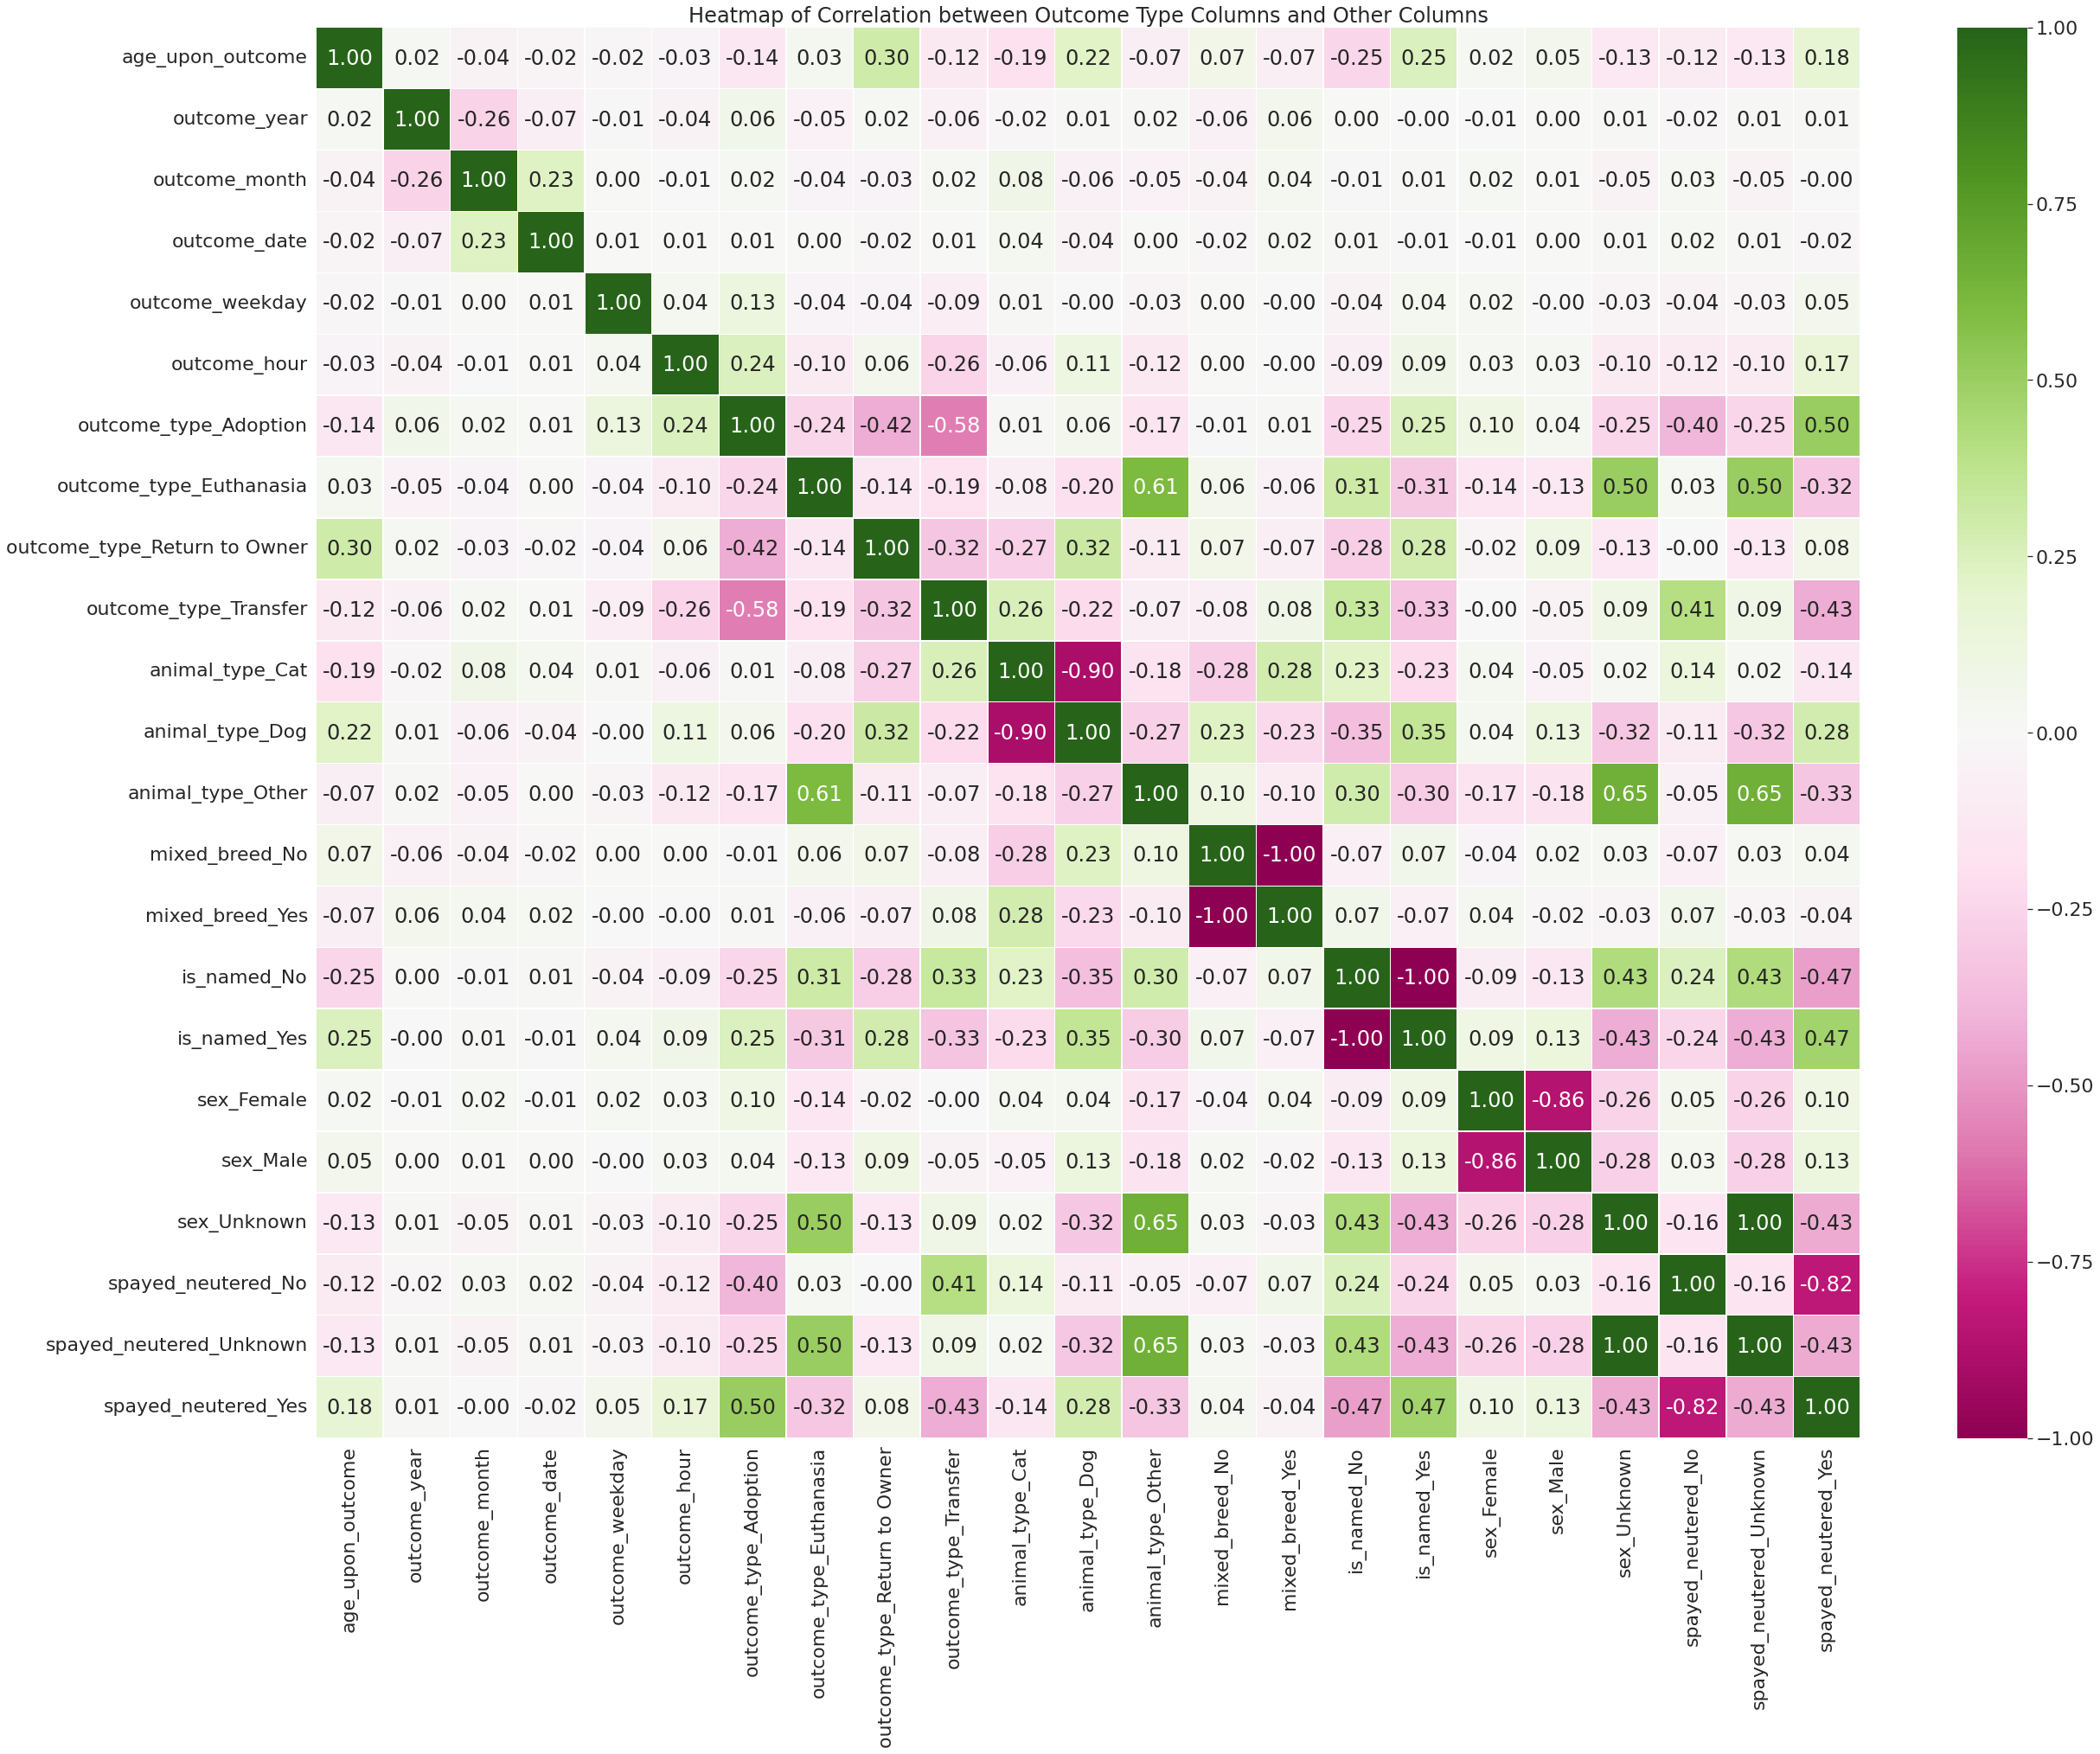

In [81]:
# Computing the correlation matrix
dtf_corr = dtf_encoded.corr(method="pearson")

# Plotting the heatmap
plt.subplots(figsize=(40,30))
sns.set(font_scale=2)
sns.heatmap(dtf_corr, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap="PiYG", cbar=True, linewidths=0.5)
plt.title('Heatmap of Correlation between Outcome Type Columns and Other Columns')
plt.show()

We can see that columns like 'outcome_date', 'outcome_month' and 'outcome_year' have little impact on the target features ('outcome_type_Adoption/Euthanasia/Return to Owner/Transfer'), and may not add new insights predicting it. They do have correlations with each other though (respectively).

-----------------add more comments.

Comparing to 'outcome_subtype' column:

In [82]:
# Defining columns to encode
columns_to_encode = ['outcome_type', 'outcome_subtype']

# Encoding columns using one-hot encoding
dtf_encoded_outcome = pd.get_dummies(dtf, columns=columns_to_encode, prefix=columns_to_encode)

# Defining outcome type columns and outcome subtype columns
outcome_type_columns = [col for col in dtf_encoded_outcome.columns if 'outcome_type' in col]
outcome_subtype_columns = [col for col in dtf_encoded_outcome.columns if 'outcome_subtype' in col]

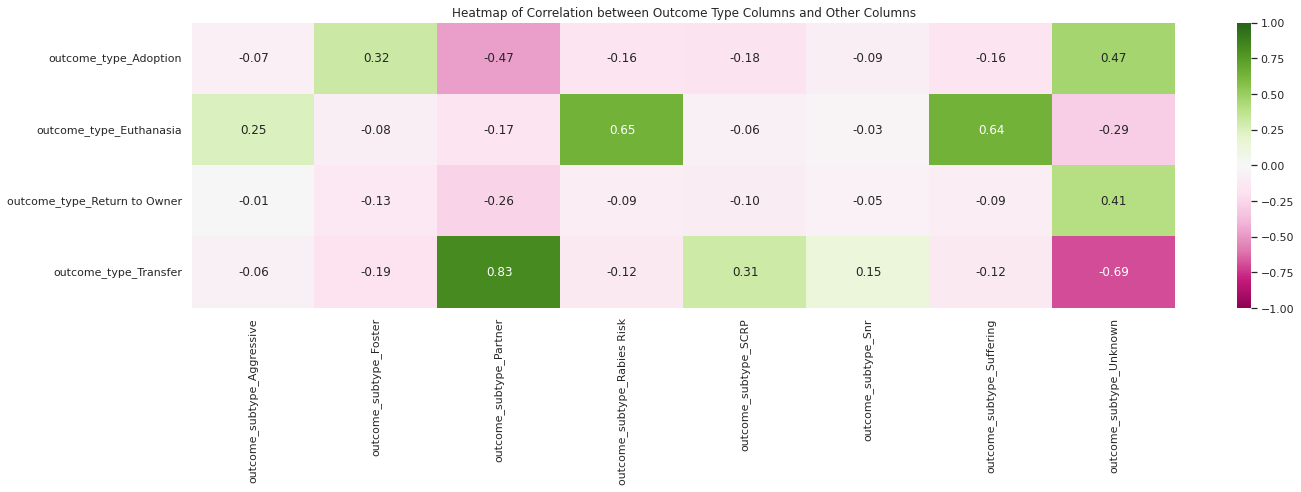

In [83]:
# Computing the correlation matrix
dtf_corr = dtf_encoded_outcome[outcome_type_columns + outcome_subtype_columns].corr(method="pearson")

# Plotting the heatmap
sns.set(font_scale=1)
plt.subplots(figsize=(20, 7))
sns.heatmap(dtf_corr.loc[outcome_type_columns, outcome_subtype_columns], vmin=-1, vmax=1, annot=True, cmap='PiYG',
        fmt=".2f")
plt.title('Heatmap of Correlation between Outcome Type Columns and Other Columns')
plt.tight_layout()
plt.show()

--------We can see that 'outcome_subtype_Barn' have 0 correlation to all outcome types. This is a column that we might delete...

***

In [55]:
# fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))
# fig.subplots_adjust(wspace=0.4, hspace=1)

# numeric_X = X.select_dtypes(include='number')
# for i, feature in enumerate(numeric_X.columns):
#     row, col = divmod(i, 4)
#     sns.boxplot(x=X[feature], ax=axes[row, col])
#     axes[row, col].set_title(feature)

# plt.show()

***

## Improved ML Model

In [54]:
def fit_and_predict(encoded_data, model, scaler):
    # Prepare the data
    X = np.array(encoded_data)
    y, outcome_names = pd.factorize(dtf['outcome_type'])

    # Split the data into training, validation, and testing sets
    # (0.25 x 0.8 = 0.2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # Scale the features in the training the datasets X_train, X_val and X_test
    x_train_scaled = scaler.fit_transform(X_train)
    x_val_scaled = scaler.transform(X_val)
    x_test_scaled = scaler.transform(X_test)

    # Train the model
    model.fit(x_train_scaled, y_train)

    # Make predictions on validation set
    y_val_pred = model.predict(x_val_scaled)

    # Evaluate the model on validation set
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_accuracy}")

    # Make predictions on test set
    y_test_pred = model.predict(x_test_scaled)

    # Evaluate the model on test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy}")

### Model 0

In [55]:
# Dropping 'animal_id' column from the dataframe
dtf_model = dtf.drop('animal_id', axis=1)

# Dropping 'outcome_type' column (the target feature) from the dataframe
dtf_model = dtf_model.drop('outcome_type', axis=1)

# Converting all columns to the category data type
dtf_model = dtf_model.astype('category')

In [56]:
# Columns for one-hot encoding
columns_for_one_hot = ['animal_type', 'mixed_breed', 'is_named', 'outcome_subtype', 'sex', 'spayed_neutered']

# Columns for feature hashing
columns_for_feature_hashing = ['breed', 'color1', 'color2']

In [57]:
# One-hot encoding
encoded_one_hot = pd.get_dummies(dtf_model[columns_for_one_hot])

--------------takes 1.5 minutes. Add a skip option.

In [58]:
# Feature hashing
# Initialize an empty DataFrame for hashed features
hashed_features = pd.DataFrame(index=dtf_model.index)

n_features_breed = 200
n_features_color = 50

# Feature hashing for 'breed' column
hasher_breed = FeatureHasher(n_features=n_features_breed, input_type='string')

# Feature hashing for 'color1' column
hasher_color1 = FeatureHasher(n_features=n_features_color, input_type='string')

# Feature hashing for 'color2' column
hasher_color2 = FeatureHasher(n_features=n_features_color, input_type='string')

hashing_map = {
    'breed': (hasher_breed, n_features_breed),
    'color1': (hasher_color1, n_features_color),
    'color2': (hasher_color2, n_features_color)
}

for column, pair in hashing_map.items():
    hasher, n = pair[0], pair[1]
    hashed_column = hasher.fit_transform(dtf_model[column])
    hashed_column_df = pd.DataFrame(hashed_column.toarray(), columns=[f"{column}_hash_{i}" for i in range(n)])
    hashed_features = pd.concat([hashed_features, hashed_column_df], axis=1)

In [59]:
# Concatenate the encoded data
encoded_data = pd.concat([encoded_one_hot, hashed_features,
                        dtf_model.drop(columns_for_one_hot + columns_for_feature_hashing, axis=1)], axis=1)

# Drop rows with missing values from the encoded_data DataFrame
encoded_data = encoded_data.dropna()

# Getting the column names after one-hot encoding
column_names = encoded_data.columns

In [60]:
# Initialize StandardScaler object for feature scaling
scaler = StandardScaler()

In [66]:
# Initialize the model
model = AdaBoostClassifier(n_estimators=250)

In [64]:
# # Initialize the model
# model = XGBClassifier(objective='multi:softmax', num_class=6, random_state=42)

In [71]:
encoded_data

,animal_type_Cat,animal_type_Dog,animal_type_Other,mixed_breed_No,mixed_breed_Yes,is_named_No,is_named_Yes,outcome_subtype_Aggressive,outcome_subtype_At Vet,outcome_subtype_Behavior,...,color2_hash_46,color2_hash_47,color2_hash_48,color2_hash_49,age_upon_outcome,outcome_year,outcome_month,outcome_date,outcome_weekday,outcome_hour
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.038462,2014,7,31,1,16
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,2013,11,30,3,11
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,2014,6,30,1,14
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.000000,2014,6,30,6,15
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.416667,2014,7,31,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80593,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.000000,2018,4,30,0,15
80594,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.000000,2018,4,30,0,15
80595,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.000000,2018,4,30,0,15
80596,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.019231,2018,4,30,0,15


In [72]:
pd.factorize(dtf['outcome_type'])

(array([0, 0, 1, ..., 1, 1, 3]),
 Index(['Transfer', 'Adoption', 'Euthanasia', 'Return to Owner', 'Died',
        'Disposal'],
       dtype='object'))

In [81]:
dtf['outcome_type'].isnull().sum()

0

In [74]:
# Prepare the data
# X = np.array(encoded_data)
# y, outcome_names = pd.factorize(dtf['outcome_type'])
X = encoded_data
y = dtf['outcome_type']

# Split the data into training, validation, and testing sets
# (0.25 x 0.8 = 0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [80519, 80598]

In [67]:
fit_and_predict(encoded_data, model, scaler)

ValueError: Found input variables with inconsistent numbers of samples: [80519, 80598]

### Training the model and predicting

In [84]:
# Dropping 'animal_id' column from the dataframe
dtf_model = dtf.drop('animal_id', axis=1)

# Converting all columns to the category data type
dtf_model = dtf_model.astype('category')

In [88]:
# Columns for one-hot encoding
columns_for_one_hot = ['animal_type', 'breed', 'mixed_breed', 'color1', 'color2', 'is_named', 'outcome_subtype',
                    'outcome_type', 'sex', 'spayed_neutered']

In [93]:
# One-hot encoding
encoded_data = pd.get_dummies(dtf_model[columns_for_one_hot])

In [94]:
# Getting all the target columns (columns that include 'outcome_type' in their name)
outcome_type_columns = [col for col in encoded_data.columns if 'outcome_type' in col]

<font color='#f542b0'>---------------takes 1.5 minutes. Add a skip option.</font>

In [98]:
for outcome_column in outcome_type_columns:
    # Prepare the data
    X = encoded_data.drop(outcome_type_columns, axis=1)
    y = encoded_data[outcome_column]
    
    # Split the data into training, validation, and testing sets
    # (0.25 x 0.8 = 0.2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    # Scale the features in the training the datasets X_train, X_val and X_test
    x_train_scaled = scaler.fit_transform(X_train)
    x_val_scaled = scaler.transform(X_val)
    x_test_scaled = scaler.transform(X_test)
    
    # Initialize the model
    model = AdaBoostClassifier(n_estimators=250)

    # # Initialize the model
    # model = RandomForestClassifier(n_estimators=250, criterion='gini', class_weight='balanced_subsample', bootstrap=True,
    #                         oob_score=True)
    
    # Train the model
    model.fit(x_train_scaled, y_train)
    
    # Make predictions on validation set
    y_val_pred = model.predict(x_val_scaled)
    
    # Evaluate the model on validation set
    val_accuracy = accuracy_score(y_val, y_val_pred)
    validation_accuracies.append(val_accuracy)
    print(f"Validation Accuracy for {outcome_column}: {val_accuracy}")
    
    # Make predictions on test set
    y_test_pred = model.predict(x_test_scaled)
    
    # Evaluate the model on test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)
    print(f"Test Accuracy for {outcome_column}: {test_accuracy}\n")

    # Store feature importances
    feature_importances[outcome_column] = model.feature_importances_

Validation Accuracy for outcome_type_Adoption: 0.8265591261272704
Test Accuracy for outcome_type_Adoption: 0.8339260764638639

Validation Accuracy for outcome_type_Euthanasia: 0.9968880985647148
Test Accuracy for outcome_type_Euthanasia: 0.9965705576019307

Validation Accuracy for outcome_type_Return to Owner: 0.8384351581353995
Test Accuracy for outcome_type_Return to Owner: 0.8448494855836403

Validation Accuracy for outcome_type_Transfer: 0.9794868538041407
Test Accuracy for outcome_type_Transfer: 0.9801219357297092



### Evaluating the model

In [99]:
# Calculate average validation accuracy
avg_val_accuracy = np.mean(validation_accuracies)
print(f"Average Validation Accuracy: {avg_val_accuracy}")

# Calculate average test accuracy
avg_test_accuracy = np.mean(test_accuracies)
print(f"Average Test Accuracy: {avg_test_accuracy}")

Average Validation Accuracy: 0.9103423091578814
Average Test Accuracy: 0.9138670138447861


In [111]:
# Define the number of top features to display
top_n_features = 15

# Calculate average feature importances across all outcome types
avg_feature_importances = np.mean([importances for importances in feature_importances.values()], axis=0)

# Sort and get the indices of top N most important features
top_feature_indices = avg_feature_importances.argsort()[-top_n_features:][::-1]

In [112]:
# Print top N most important features
print(f"Top {top_n_features} most important features:\n")

for index in top_feature_indices:
    print(f"{X.columns[index]}: {avg_feature_importances[index]}")

Top 15 most important features:

breed_Domestic Shorthair: 0.185
animal_type_Cat: 0.176
breed_Domestic Mediumhair: 0.062
breed_Domestic Longhair: 0.053
breed_Siamese: 0.041
animal_type_Other: 0.024
outcome_subtype_Unknown: 0.017
outcome_subtype_Aggressive: 0.015
breed_Rabbit: 0.015
breed_Pit Bull: 0.013999999999999999
color1_Brown Tabby: 0.013000000000000001
spayed_neutered_Yes: 0.011
color1_Black: 0.011
color1_Tan: 0.01
outcome_subtype_SCRP: 0.01


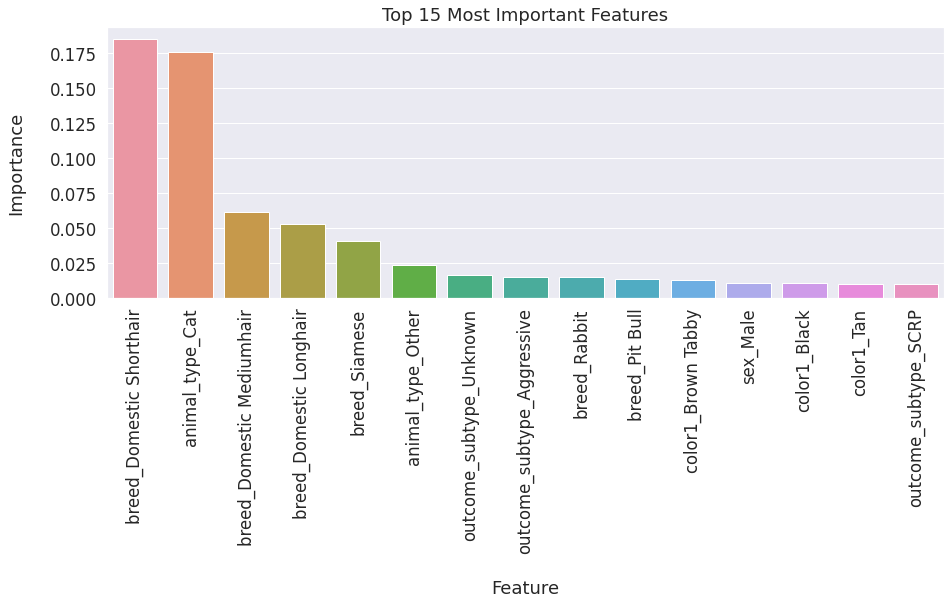

In [115]:
# Create a DataFrame with feature importances
importances_df = pd.DataFrame({'importance': avg_feature_importances[top_feature_indices],
                               'feature': np.array(encoded_data.columns)[top_feature_indices]})

# Set seaborn font scale
sns.set(font_scale=1.50)

# Create a bar plot of top N most important features
plt.figure(figsize=(15, 5))
sns.barplot(x='feature', y='importance', data=importances_df)
plt.xticks(rotation=90)
plt.xlabel('Feature', labelpad=25)
plt.ylabel('Importance', labelpad=25)
plt.title(f'Top {top_n_features} Most Important Features')
plt.show()

### Model 2

In [217]:
# Dropping 'animal_id' column from the dataframe
dtf_model = dtf.drop('animal_id', axis=1)

# Converting all columns to the category data type
dtf_model = dtf_model.astype('category')

In [218]:
# Columns for one-hot encoding
columns_for_one_hot = ['animal_type', 'breed', 'mixed_breed', 'color1', 'color2', 'is_named', 'outcome_subtype',
                    'outcome_type', 'sex','spayed_neutered']

# One-hot encoding
encoded_data = pd.get_dummies(dtf_model[columns_for_one_hot])

In [219]:
# Getting all the target columns (columns that include 'outcome_type' in their name)
outcome_type_columns = [col for col in encoded_data.columns if 'outcome_type' in col]

In [220]:
# Initialize StandardScaler object for feature scaling
scaler = StandardScaler()

In [221]:
# Initialize lists to store accuracy scores
validation_accuracies = []
test_accuracies = []

# Initialize an empty dictionary to store feature importances
feature_importances = {}

In [222]:
for outcome_column in outcome_type_columns:
    # Prepare the data
    X = encoded_data.drop(outcome_type_columns, axis=1)
    y = encoded_data[outcome_column]
    
    # Split the data into training, validation, and testing sets
    # (0.25 x 0.8 = 0.2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    # Scale the features in the training the datasets X_train, X_val and X_test
    x_train_scaled = scaler.fit_transform(X_train)
    x_val_scaled = scaler.transform(X_val)
    x_test_scaled = scaler.transform(X_test)
    
    # Initialize the model
    model = AdaBoostClassifier(n_estimators=250)
    
    # Train the model
    model.fit(x_train_scaled, y_train)
    
    # Make predictions on validation set
    y_val_pred = model.predict(x_val_scaled)
    
    # Evaluate the model on validation set
    val_accuracy = accuracy_score(y_val, y_val_pred)
    validation_accuracies.append(val_accuracy)
    print(f"Validation Accuracy for {outcome_column}: {val_accuracy}")
    
    # Make predictions on test set
    y_test_pred = model.predict(x_test_scaled)
    
    # Evaluate the model on test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)
    print(f"Test Accuracy for {outcome_column}: {test_accuracy}\n")

    # Store feature importances
    feature_importances[outcome_column] = model.feature_importances_

KeyboardInterrupt: 

### Evaluating 2

In [ ]:
# Calculate average validation accuracy
avg_val_accuracy = np.mean(validation_accuracies)
print(f"Average Validation Accuracy: {avg_val_accuracy}")

# Calculate average test accuracy
avg_test_accuracy = np.mean(test_accuracies)
print(f"Average Test Accuracy: {avg_test_accuracy}")

In [ ]:
# Define the number of top features to display
top_n_features = 25

# Calculate average feature importances across all outcome types
avg_feature_importances = np.mean([importances for importances in feature_importances.values()], axis=0)

# Sort and get the indices of top N most important features
top_feature_indices = avg_feature_importances.argsort()[-top_n_features:][::-1]

In [ ]:
# Print top N most important features
print(f"\nTop {top_n_features} most important features:")
for index in top_feature_indices:
    print(f"{X.columns[index]}: {avg_feature_importances[index]}")

In [ ]:
# Create a DataFrame with feature importances
importances_df = pd.DataFrame({'importance': avg_feature_importances[top_feature_indices],
                               'feature': np.array(encoded_data.columns)[top_feature_indices]})

# Set seaborn font scale
sns.set(font_scale=1.50)

# Create a bar plot of top N most important features
plt.figure(figsize=(15, 5))
sns.barplot(x='feature', y='importance', data=importances_df)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title(f'Top {top_n_features} Most Important Features')
plt.show()

### Model 3

In [56]:
# Dropping 'animal_id' column from the dataframe
dtf_model = dtf.drop('animal_id', axis=1)

# Dropping 'outcome_type' column (the target feature) from the dataframe
dtf_model = dtf_model.drop('outcome_type', axis=1)

# Converting all columns to the category data type
dtf_model = dtf_model.astype('category')

In [57]:
# Columns for one-hot encoding
columns_for_one_hot = ['animal_type', 'breed', 'mixed_breed', 'color1', 'color2', 'is_named', 'outcome_subtype', 'sex',
                    'spayed_neutered']

# One-hot encoding
encoded_data = pd.get_dummies(dtf_model[columns_for_one_hot])

# Getting the column names after one-hot encoding
column_names = encoded_data.columns

In [58]:
# Prepare the data
X = np.array(encoded_data)
y, outcome_names = pd.factorize(dtf['outcome_type'])

In [59]:
# Split the data into training, validation, and testing sets
# (0.25 x 0.8 = 0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [60]:
# Initialize StandardScaler object for feature scaling
scaler = StandardScaler()

<font color='#f542b0'>---------------takes 2 minutes. Add a skip option.</font>

In [61]:
# Scale the features in the training the datasets X_train, X_val and X_test
x_train_scaled = scaler.fit_transform(X_train)
x_val_scaled = scaler.transform(X_val)
x_test_scaled = scaler.transform(X_test)

In [62]:
# Initialize the model
model = RandomForestClassifier(n_estimators=250, criterion='gini', 
                                       class_weight='balanced_subsample', bootstrap=True, oob_score=True)

In [ ]:
# # Initialize the model
# model = AdaBoostClassifier(n_estimators=250)

In [ ]:
# # Initialize the model
# model = XGBClassifier(objective='multi:softmax', num_class=len(y.unique()), random_state=42)

<font color='#f542b0'>---------------takes _ minutes. Add a skip option.</font>

In [64]:
# Train the model
model.fit(x_train_scaled, y_train)

In [ ]:
# Make predictions on validation set
y_val_pred = model.predict(x_val_scaled)

In [ ]:
# Evaluate the model on validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")

In [ ]:
# Make predictions on test set
y_test_pred = model.predict(x_test_scaled)

In [ ]:
# Evaluate the model on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

### Evaluate 3

In [ ]:
# Get feature importances
feature_importances = model.feature_importances_

In [ ]:
# Print feature importances
print("Feature Importances:")
for i, importance in enumerate(feature_importances):
    print(f"Feature {i}: {importance}")

In [ ]:
importances = pd.DataFrame({'importance': feature_importances, 'feature': column_names}, 
                           index=column_names).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15])

In [ ]:
# # Explain model predictions using SHAP
# explainer = shap.Explainer(model, X_train)
# shap_values = explainer(X_test)

In [ ]:
# # Visualize SHAP values
# shap.summary_plot(shap_values, X_test)

## Another Model

In [124]:
# Dropping 'animal_id' column from the dataframe
dtf_model = dtf.drop('animal_id', axis=1)

# # Converting all columns to the category data type
# dtf_model = dtf_model.astype('category')

# Separate features and target variable
X = dtf_model.drop('outcome_type', axis=1)  # Features
y = dtf_model['outcome_type']  # Target variable

# Split the data into training, validation, and testing sets
# (0.25 x 0.8 = 0.2)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Initialize the model
model = RandomForestClassifier(n_estimators=250, criterion='gini', 
                                       class_weight='balanced_subsample', bootstrap=True, oob_score=True)

model.fit(X_train_encoded, y_train)

# Make predictions on the validation set
y_val_pred = model.predict(X_val_encoded)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))

# Make predictions on the test set
y_test_pred = model.predict(X_test_encoded)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Validation Accuracy: 85.62%
Test Accuracy: 84.93%


In [ ]:
# Dropping 'animal_id' column from the dataframe
dtf_model = dtf.drop('animal_id', axis=1)

# # Converting all columns to the category data type
# dtf_model = dtf_model.astype('category')

# Getting the column names after one-hot encoding
columns_names = encoded_data.columns

# # Converting the resulting DataFrame to a NumPy array
# encoded_model_array = np.array(encoded_data)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=250, criterion='gini', 
                                        class_weight='balanced_subsample', bootstrap=True, oob_score=True)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

In [ ]:
feature_importances = rf_classifier.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': columns_names}, 
                           index=columns_names).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15])